# [Toxic Comment Classification Challenge - Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
### 악성 댓글을 식별하고 분류하기
* 참고 : https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

In [1]:
# 출력데이터가 지저분하게 보이지 않도록 warnings을 불러왔다.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np

# 시각화 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

In [3]:
color = sns.color_palette()
sns.set_style("dark")

%matplotlib inline

In [4]:
train = pd.read_csv("data/train.csv")
train.shape

(159571, 8)

In [5]:
test = pd.read_csv("data/test.csv")
test.shape

(153164, 2)

In [6]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [7]:
nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train + nrow_test
print("* 전체 데이터에서 학습과 테스트셋의 비율로 학습셋이 약간 더 많다.")
print("       : train  : test")
print("행수    :", nrow_train, ":", nrow_test)
print("전체비율 :", round(nrow_train*100/sum), "    :", round(nrow_test*100/sum))

* 전체 데이터에서 학습과 테스트셋의 비율로 학습셋이 약간 더 많다.
       : train  : test
행수    : 159571 : 153164
전체비율 : 51     : 49


In [8]:
print("학습셋의 결측치")
null_check=train.isnull().sum()
print(null_check)
print("테스트셋의 결측치")
null_check=test.isnull().sum()
print(null_check)
print("\"unknown\"으로 되어 있는 NA데이터 채우기")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

학습셋의 결측치
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
테스트셋의 결측치
id              0
comment_text    0
dtype: int64
"unknown"으로 되어 있는 NA데이터 채우기


In [9]:
# 2번째 컬럼부터 데이터를 따로 담아본다.
train.iloc[:,2:].head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [10]:
x = train.iloc[:,2:].sum()
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
# row에 등장하는 숫자를 더한다.
rowsums = train.iloc[:,2:].sum(axis=1)
rowsums[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    4
7    0
8    0
9    0
dtype: int64

In [12]:
# row의 각 컬럼을 더한수가 0인 데이터는 clean 컬럼을 만들어 담아준다.
train['clean'] = (rowsums==0)

In [13]:
# 악플이 아닌 데이터의 수
train['clean'].sum()

print("전체 코멘트 수 = ",len(train))
print("전체 클린 코멘트 수 = ", train['clean'].sum())
print("전체 태그 =",x.sum())

전체 코멘트 수 =  159571
전체 클린 코멘트 수 =  143346
전체 태그 = 35098


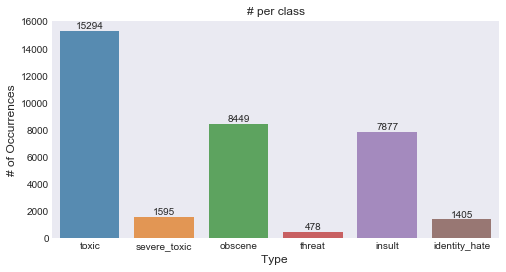

In [14]:
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)

plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

# 레이블 추가
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [15]:
# 6개 항목 모두를 만족하는 데이터는 31건이다.
x = rowsums.value_counts()
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

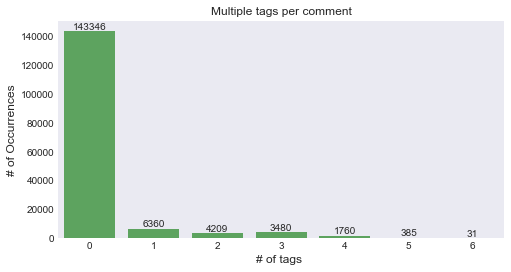

In [16]:
plt.figure(figsize = (8,4))
ax = sns.barplot(x.index, x.values, alpha = 0.8,color = color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [17]:
temp_df = train.iloc[:,2:-1]
temp_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


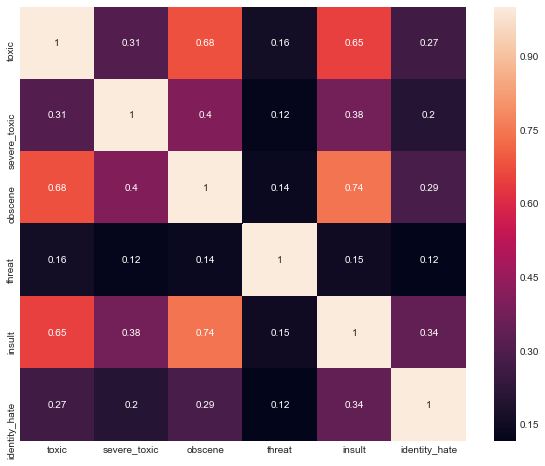

In [18]:
# 악성댓글의 각 항목이 얼마나 연관관계가 있는지
# obscene 와 threat 은 연관관계가 높다. 다음으로 obscene 와 toxic 도 연관관계가 높다
corr = temp_df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

https://pandas.pydata.org/pandas-docs/stable/style.html

In [19]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [20]:
# Crosstab
# 6개 클래스를 크로스해서 보기는 어렵기 때문에 다른 태그와 함께 유해성을 본다.

main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# 체스판처럼 셀 배경색을 구분해 본다.
out = out.style.apply(highlight_min,axis=0)
out

In [21]:
merge = pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df = merge.reset_index(drop=True)
df.shape

(312735, 2)

In [22]:
# 각 댓글의 문장 수
df['count_sent'] = df['comment_text'].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [23]:
# 각 댓글의 단어 수
df['count_word'] = df['comment_text'].apply(lambda x: len(str(x).split()))

In [24]:
# 고유한 단어 수
df['count_unique_word'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

In [25]:
# 글자수
df['count_letters'] = df['comment_text'].apply(lambda x: len(str(x)))

In [26]:
# 구두점 수
df['count_punctuations'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [27]:
# 대문자 수
df['count_words_upper'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [28]:
# 타이틀 단어 수
df['count_words_title'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [29]:
# 불용어 수
eng_stopwords = set(stopwords.words("english"))
df['count_stopwords'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

In [30]:
# 단어 길이 중간값
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [31]:
df.shape

(312735, 11)

In [32]:
# 각 코멘트의 유니크한 단어 수
df['word_unique_percent'] = df['count_unique_word'] * 100 / df['count_word']# 구두점 비율
df['punct_percent'] = df['count_punctuations'] * 100 / df['count_word']

In [33]:
# train, test feature로 나눔
train_feats = df.iloc[0:len(train),]
test_feats = df.iloc[len(train):,]
# 태그 연결
train_tags = train.iloc[:,2:]
train_feats = pd.concat([train_feats, train_tags], axis=1)

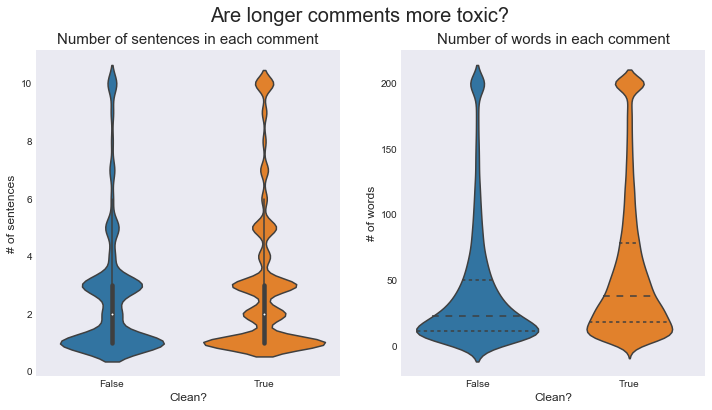

In [34]:
train_feats['count_sent'].loc[train_feats['count_sent'] > 10] = 10 
plt.figure(figsize=(12,6))

# 문장의 길이가 유해함과 연관이 있는지
# sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?", fontsize=20)
sns.violinplot(y='count_sent', x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word'] > 200] = 200
plt.subplot(122)
sns.violinplot(y='count_word', x='clean', data=train_feats, split=True, inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()